# **Financial Applicactions with ML & AI**

<img style="float: right;" src="https://github.com/torreblanca99/course_financial_applications/blob/develop/docs/img/logo_bourbaki.png?raw=1" width="100"/>

## **Module II:** Value Risk
#### Topic: Monte Carlo for Options Value

##### Name: Julio César Avila Torreblanca

- **Objective**: apply Monte Carlo to value options.

- **Contents**:
    - Notes:
        - Monte Carlo
    - Code:
        1. Libraries and parameters
        2. Read Data (Asset example)
        3. Preparing Data
        4. Modeling
        5. Evaluation
----

# Class Notes: Monte Carlo Method

## Introduction to the Monte Carlo Method

The Monte Carlo method is a statistical technique that utilizes randomness to solve problems that might be deterministic in nature. It leverages the law of large numbers to approximate the solution to complex problems, such as integrals, optimization, and simulation of systems. This technique is widely used in finance for the valuation of derivatives and risk management.

## Key Features of the Monte Carlo Method

### Law of Large Numbers

One of the fundamental principles behind the Monte Carlo method is the law of large numbers, which states that the arithmetic mean of a large number of independent and identically distributed variables tends to converge to the expected value.

- **Formal Definition**:
  Let $ X_1, X_2, \ldots, X_n $ be a sequence of independent, identically distributed random variables with mean $ \mu $ and finite variance $ \sigma^2 $. Then,

  $$
  \frac{X_1 + X_2 + \cdots + X_n}{n} \rightarrow \mu
  $$

  as $ n \rightarrow \infty$.

### Steps in the Monte Carlo Method

1. **Define Random Variables**: Identify the random variables whose expected value represents the quantity of interest.
2. **Sample Generation**: Generate a large number of samples from the probability distribution of these random variables.
3. **Compute Empirical Mean**: Calculate the empirical mean of the sampled values, which serves as an approximation to the expected value of the random variable.

## Application of Monte Carlo in Financial Derivatives

### European Option Pricing

The price of a European option can be viewed as the expected payoff of the option discounted to present value using the risk-free rate. The Monte Carlo method approximates this expectation by simulating multiple scenarios of the underlying asset's price at expiration.

- **Mathematical Expression**:
  
  The price of a European call option is expressed as:
  
  $$
  C(S_T,T) = e^{-rT} \mathbb{E}[\max(S_T - K, 0)]
  $$

  where:
  - $ S_T $ is the simulated price of the underlying asset at expiration.
  - $ K $ is the strike price.
  - $ r $ is the risk-free interest rate.
  - $ T $ is the time to expiration.
  
  Simulate $ S_T $ using the geometric Brownian motion model:
  
  $$
  S_T = S_0 \exp\left\{ \left(r - \frac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}Z \right\}
  $$

  where $ Z \sim \mathcal{N}(0, 1) $.

### Advantages and Limitations

- **Advantages**:
  - Flexibility in handling complex options and path-dependent features.
  - Applicable to a wide range of financial instruments beyond simple European options.

- **Limitations**:
  - Computationally intensive, particularly for high-dimensional problems.
  - Accuracy depends on the number of simulated paths, with more paths leading to greater precision but higher computational cost.

### Conclusion

The Monte Carlo method is an effective tool for approximating the value of financial derivatives in situations where analytical solutions are complex or unavailable. Its 
reliance on randomness and simulation offers a versatile approach to tackling a variety of financial models.

---

# 1. Librerías y parámetros

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import math 
from scipy.stats import norm

import matplotlib.pyplot as plt
from tqdm import tqdm

# 2. Rading data

In [3]:
data = yf.download(
        tickers = "GOOGL ^IRX", # options: GOOGL: Google, ^IRX: 13 Week Treasury Bill
        period = "1y", # one year information
        interval = "1d", # daily information
    ).loc[:, 'Close']

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Ticker,GOOGL,^IRX
Date,,
2024-03-25,NaN,5.218
2024-03-26,149.953079,5.218
2024-03-27,150.152115,5.215
2024-03-28,150.211838,5.203
2024-04-01,154.750153,5.218
...,...,...
2025-03-19,163.889999,4.190
2025-03-20,162.800003,4.182
2025-03-21,163.990005,4.185


# 3. Preparing Data

## 3.1 Sttructure

In [4]:
# rename columns
data.rename(columns={'^IRX':'IRX'}, inplace=True)

In [5]:
# change percentage to decimal
data['IRX'] = data['IRX']/100

## 3.2 Transformations

### Google

#### Log- Returns

In [6]:
# log-returns
data['log_ret'] = np.log(data['GOOGL']) - np.log(data['GOOGL'].shift(1))

In [7]:
data.head()

Ticker,GOOGL,IRX,log_ret
Date,,,
2024-03-25,NaN,0.05218,NaN
2024-03-26,149.953079,0.05218,NaN
2024-03-27,150.152115,0.05215,0.001326
2024-03-28,150.211838,0.05203,0.000398
2024-04-01,154.750153,0.05218,0.029765


<Axes: >

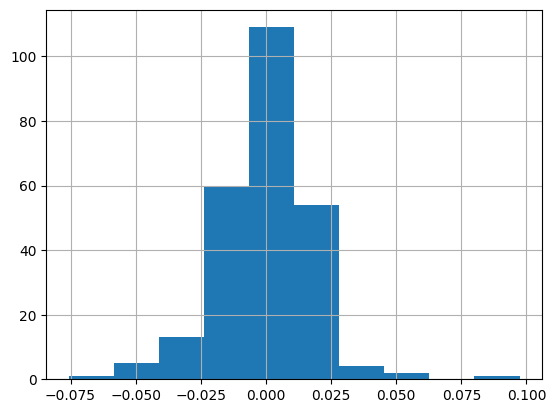

In [8]:
data.log_ret.hist()

#### Volatility

In [9]:
# computing volatility
dates_vol = data.index

data['Vol_GOOGL'] = np.nan
for date in dates_vol[125:]:  # 120 days for 6 months (without weekends)
    data_for_vol = dates_vol[(date - dates_vol < pd.Timedelta(days=180)) & (date - dates_vol >= pd.Timedelta(days=0))]
    data.loc[date, 'Vol_GOOGL'] = np.std(data['log_ret'][data_for_vol].values, ddof=1)*np.sqrt(252) # anualized volatility

data

Ticker,GOOGL,IRX,log_ret,Vol_GOOGL
Date,,,,
2024-03-25,NaN,0.05218,NaN,NaN
2024-03-26,149.953079,0.05218,NaN,NaN
2024-03-27,150.152115,0.05215,0.001326,NaN
2024-03-28,150.211838,0.05203,0.000398,NaN
2024-04-01,154.750153,0.05218,0.029765,NaN
...,...,...,...,...
2025-03-19,163.889999,0.04190,0.019843,0.301438
2025-03-20,162.800003,0.04182,-0.006673,0.300354
2025-03-21,163.990005,0.04185,0.007283,0.299311


In [10]:
# drop  null values
data = data[data['Vol_GOOGL'].notnull()]

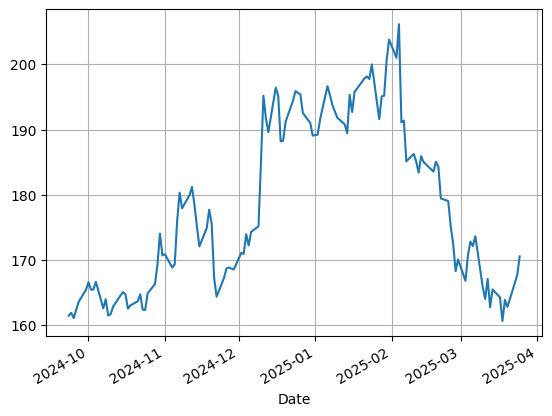

In [11]:
data['GOOGL'].plot()
plt.grid()

<Axes: xlabel='Date'>

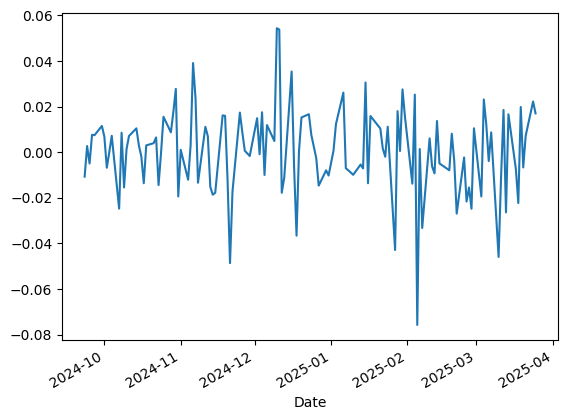

In [12]:
data['log_ret'].plot()

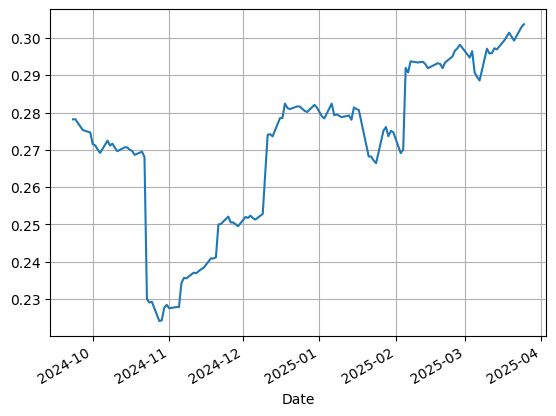

In [13]:
data['Vol_GOOGL'].plot()
plt.grid()

# 4. Modeling with Monte Carlo simulation

The stochastic differential equation that defines the path followed by an asset is:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where:
- $ S_t $ represents the price of the asset at time $ t $,
- $ \mu $ is the expected annual return,
- $ \sigma $ represents the implicit market volatility.

To predict the predict $S_T$, Create a Geometric Brownian Motion simulator:

$$
S_T = S_0 \exp{ \left( r - \frac{\sigma^2}{2}T + \sigma \epsilon \sqrt{T} \right)}
$$

where $\epsilon$ is a simulation of a Normal distribution.

This equation will provide us with the simulation of the asset's price in the future by carrying out simulations of standard normal random variables. This will help us find the option price.

As an extra, solving this equation is quite complex, but it can be done using a tool called the Black-Scholes equation.

## 4.1 One value

In [14]:
data.tail(15)

Ticker,GOOGL,IRX,log_ret,Vol_GOOGL
Date,,,,
2025-03-05,172.820969,0.04205,0.012212,0.290688
2025-03-06,172.151733,0.04197,-0.003880,0.289584
2025-03-07,173.660004,0.04197,0.008723,0.288609
2025-03-10,165.869995,0.04185,-0.045895,0.297149
2025-03-11,164.039993,0.04195,-0.011094,0.295863
2025-03-12,167.110001,0.04197,0.018542,0.295962
2025-03-13,162.759995,0.04188,-0.026376,0.297247
2025-03-14,165.490005,0.04188,0.016634,0.296952
2025-03-17,164.289993,0.04188,-0.007278,0.299328


In [15]:
un_dato = data.iloc[-1,:].copy()
un_dato

Ticker
GOOGL        170.559998
IRX            0.041820
log_ret        0.017030
Vol_GOOGL      0.303704
Name: 2025-03-25 00:00:00, dtype: float64

In [16]:
valores = np.array([])

K = un_dato['GOOGL'] + 10 # Nosotros escogemos el precio de STRIKE

for i in range(10000):
    normal = np.random.standard_normal(1)
    time = 30 /360 # anual

    St = un_dato['GOOGL'] * np.exp((un_dato['IRX'] - 0.5 * un_dato['Vol_GOOGL']**2)*time + un_dato['Vol_GOOGL'] * normal * np.sqrt(time))

    valores = np.append(valores, max(St - K,0))

In [17]:
valores.mean()

np.float64(2.5737050228344165)

(array([7.868e+03, 4.180e+02, 3.830e+02, 3.150e+02, 2.230e+02, 2.080e+02,
        1.560e+02, 1.100e+02, 1.000e+02, 7.800e+01, 3.800e+01, 2.400e+01,
        2.500e+01, 2.100e+01, 1.100e+01, 9.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 5.000e+00]),
 array([ 0.        ,  2.51345844,  5.02691689,  7.54037533, 10.05383378,
        12.56729222, 15.08075067, 17.59420911, 20.10766756, 22.621126  ,
        25.13458445, 27.64804289, 30.16150134, 32.67495978, 35.18841823,
        37.70187667, 40.21533512, 42.72879356, 45.24225201, 47.75571045,
        50.2691689 ]),
 <BarContainer object of 20 artists>)

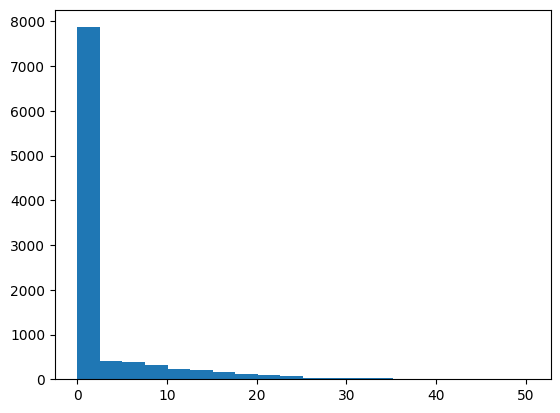

In [18]:
plt.hist(valores, bins=20)
     

## 4.2 Apply to all dataset

In [ ]:
data_cop = data[data['Vol_GOOGL'].notnull()].copy()
data_cop['call_price'] = np.nan

for index in tqdm(data_cop.index):
  valores = np.array([])
  un_dato = data_cop.loc[index, :]

  for i in range(10000): # number of simulations

    K = un_dato['GOOGL'] + 0
    normal = np.random.standard_normal(1)
    time = 30 /360 # anual 
    St = un_dato['GOOGL']*np.exp((un_dato['IRX'] - 0.5*un_dato['Vol_GOOGL']**2)*time + un_dato['Vol_GOOGL']*normal*np.sqrt(time))

    valores = np.append(valores, max(St - K,0))

  data_cop.loc[index ,'call_price'] = valores.mean()



100%|██████████| 126/126 [00:15<00:00,  7.88it/s]


In [22]:
data_cop.head()

Ticker,GOOGL,IRX,log_ret,Vol_GOOGL,call_price
Date,,,,,
2024-09-23,161.478745,0.04503,-0.010693,0.278190,5.525238
2024-09-24,161.917725,0.04495,0.002715,0.278207,5.396323
2024-09-25,161.119568,0.04487,-0.004942,0.277186,5.536990
2024-09-26,162.356720,0.04468,0.007649,0.276250,5.422927
2024-09-27,163.573929,0.04482,0.007469,0.275313,5.519416


<Axes: xlabel='Date'>

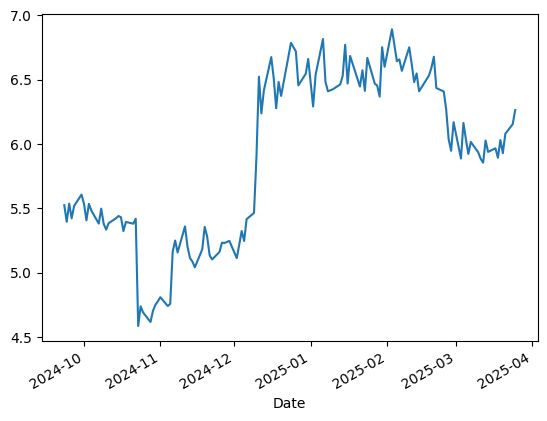

In [23]:
data_cop['call_price'].plot()

## 4.3 Compare with B-S

In [26]:
def bys_call(spot: float, 
             strike: float, 
             risk_free: float, 
             vol: float, 
             time: float) -> float:
    """
    Calculates the value of a European call option using the Black-Scholes model.

    Args:
        spot (float): Current price of the underlying asset.
        strike (float): Strike price of the option.
        risk_free (float): Risk-free interest rate (in decimal, e.g., 0.05 for 5%).
        vol (float): Volatility of the underlying asset (in decimal, e.g., 0.2 for 20%).
        tiempo (float): Time to expiration in days.

    Returns:
        float: The theoretical value of the call option. (prime to pay)
    """
    # Convert time from days to years
    time_in_years = time / 360.0

    # Calculate d1 and d2 according to the Black-Scholes formula
    d1 = (np.log(spot / strike) + (risk_free + 0.5 * vol**2) * time_in_years) / (vol * np.sqrt(time_in_years))
    d2 = d1 - vol * np.sqrt(time_in_years)

    # Calculate the call option value using the cumulative distribution function of the normal distribution
    call_value = spot * norm.cdf(d1) - strike * np.exp(-risk_free * time_in_years) * norm.cdf(d2)

    return call_value

In [36]:
data_cop['calls_Black_Scholes'] = data_cop.apply(
    lambda x: bys_call(
        spot = x['GOOGL'], 
        strike = x['GOOGL'] + 0, # 10 dollars above the current price
        risk_free = x['IRX'], 
        vol = x['Vol_GOOGL'], 
        time = 30 # days
        ), 
    axis=1
    )

<Axes: xlabel='Date'>

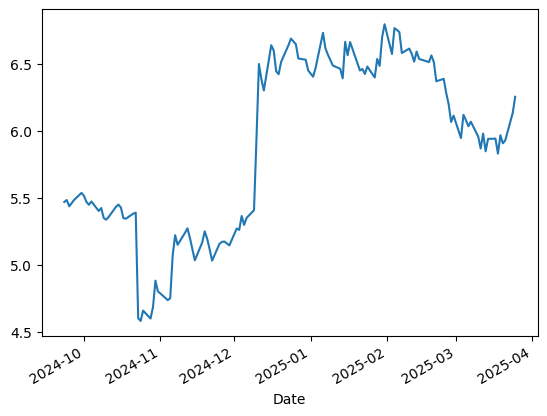

In [37]:
data_cop['calls_Black_Scholes'].plot()

In [38]:
data_cop['diferencia'] = np.abs(data_cop['call_price'] - data_cop['calls_Black_Scholes'])
data_cop 

Ticker,GOOGL,IRX,log_ret,Vol_GOOGL,call_price,calls_Black_Scholes,diferencia
Date,,,,,,,
2024-09-23,161.478745,0.04503,-0.010693,0.278190,5.525238,5.470368,0.054869
2024-09-24,161.917725,0.04495,0.002715,0.278207,5.396323,5.485005,0.088681
2024-09-25,161.119568,0.04487,-0.004942,0.277186,5.536990,5.438570,0.098420
2024-09-26,162.356720,0.04468,0.007649,0.276250,5.422927,5.461592,0.038665
2024-09-27,163.573929,0.04482,0.007469,0.275313,5.519416,5.485911,0.033504
...,...,...,...,...,...,...,...
2025-03-19,163.889999,0.04190,0.019843,0.301438,6.031251,5.967931,0.063320
2025-03-20,162.800003,0.04182,-0.006673,0.300354,5.929689,5.907439,0.022250
2025-03-21,163.990005,0.04185,0.007283,0.299311,6.080188,5.931207,0.148981


<Axes: >

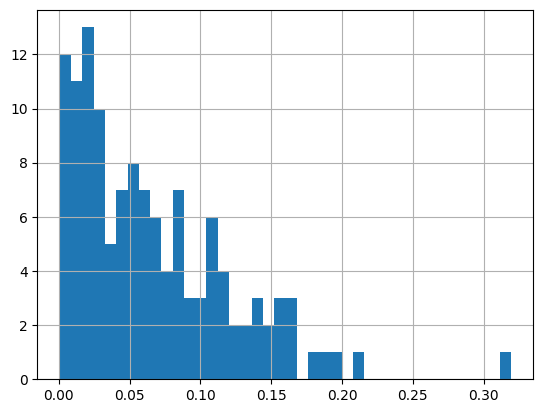

In [39]:
data_cop.diferencia.hist(bins=40)

<Axes: xlabel='Date'>

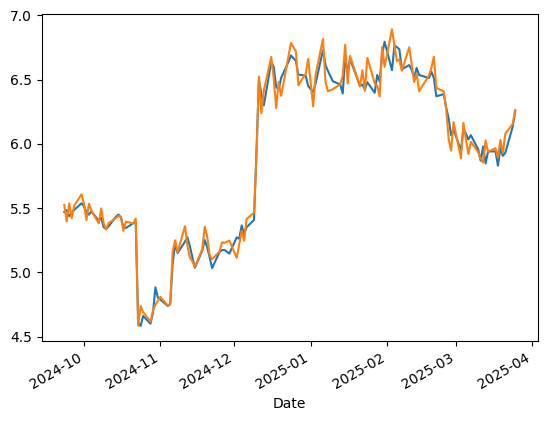

In [40]:
data_cop['calls_Black_Scholes'].plot()
data_cop['call_price'].plot()